In [1]:
import warnings
warnings.filterwarnings("ignore")
import dask
import dask.dataframe as dd
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pylab as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from matplotlib.pylab import rcParams
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import accuracy_score
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('Downloads/Dolt DB - DC - Sales.csv')  

In [3]:
df = df.drop(columns = ['state','city','county','source_url', 'sale_type', 'num_units', 'year_built', 'book', 'page', 'property_type', 'buyer_name','seller_name','property_id'])

In [4]:
df.head()

,zip5,physical_address,sale_date,sale_price
0,20003.0,1 18TH ST SE # 102,2020-11-24 00:00:00,0
1,20003.0,1 18TH ST SE # 103,2003-01-28 00:00:00,191050
2,20003.0,1 18TH ST SE # 104,2015-03-24 00:00:00,390000
3,20003.0,1 18TH ST SE # 201,2003-01-31 00:00:00,198350
4,20003.0,1 18TH ST SE # 203,2013-06-06 00:00:00,352500


for i in range(df.shape[0]):
    date = str(df.loc[i, 'sale_date'])
    df.loc[i,'sale_date'] = date[0:10]

In [5]:
df.head()

,zip5,physical_address,sale_date,sale_price
0,20003.0,1 18TH ST SE # 102,2020-11-24 00:00:00,0
1,20003.0,1 18TH ST SE # 103,2003-01-28 00:00:00,191050
2,20003.0,1 18TH ST SE # 104,2015-03-24 00:00:00,390000
3,20003.0,1 18TH ST SE # 201,2003-01-31 00:00:00,198350
4,20003.0,1 18TH ST SE # 203,2013-06-06 00:00:00,352500


In [6]:
df['sale_date'] = pd.to_datetime(df['sale_date'], infer_datetime_format=True)

In [7]:
dat = str(df.loc[0,'sale_date'])[0:4]

In [8]:
df['sale_label'] = df.sale_price//100_000

In [9]:
good_zips = [20003.0, 20002.0, 20019.0, 20001.0, 20011.0, 20036.0, 20017.0, 20005.0, 20024.0, 20007.0, 20037.0, 20012.0, 20032.0, 20008.0, 20020.0, 20015.0, 20010.0, 20018.0, 20009.0, 20016.0]

In [10]:
date_list = []
date_2020 = []
for year in range(2016,2021):
    if year < 2020:
        for month in range(1,13):
            d = str(year) + '-' + str(month)
            date_list.append(d)
    else:
        for month in range(1,13):
            d = '2020' + '-' + str(month)
            date_2020.append(d)
        

In [71]:
warnings.filterwarnings("ignore")

zip_codes = df.zip5.unique()
zip_codes = list(zip_codes[~(np.isnan(zip_codes))])
RMSES = []

#good_zips = []

scores = []
for code in good_zips:  
    #try:
        new_df = pd.DataFrame(index = range(df.shape[0]), columns = date_list)
        new_df_2020 = pd.DataFrame(index = range(df.shape[0]), columns = date_2020)

        q3, q1 = np.percentile(df[df.zip5 == code]['sale_price'], [75 ,25]) # code here
        iqr = q3 - q1
        max_val = 1.5*iqr + q3

        df_code = df[(df.zip5 == code) & (df.sale_price < max_val)]  # code here
        df_recent  = pd.DataFrame()
        df_2020 = pd.DataFrame()
        for i, row in df_code.iterrows():
            y = df_code.loc[i,'sale_date'].year
            if y >= 2016 and y < 2020 and df_code.loc[i,'sale_price'] > 0:
                df_recent = df_recent.append(row)
            elif y == 2020 and df_code.loc[i,'sale_price'] > 0:
                df_2020 = df_2020.append(row)

        df_recent = df_recent.reset_index(drop=True)
        df_2020 = df_2020.reset_index(drop=True)


        for ind in range(df_recent.shape[0]):
            y = str(df_recent.loc[ind,'sale_date'].year)
            m = str(df_recent.loc[ind,'sale_date'].month)
            day = str(df_recent.loc[ind,'sale_date'].day)
            d = y + '-' + m
            new_df.loc[ind,d] = df_recent.loc[ind, 'sale_price']

        for ind in range(df_2020.shape[0]):
            m = str(df_recent.loc[ind,'sale_date'].month)
            day = str(df_recent.loc[ind,'sale_date'].day)
            d = '2020' + '-' + m
            new_df_2020.loc[ind,d] = df_2020.loc[ind, 'sale_price']


        time_series = new_df.mean()
        test_series = new_df_2020.mean()
            
        ##########################################################################################################################

        
        inds = []
        test_inds = []
        for i in range(len(time_series)):
            inds.append(datetime.strptime(time_series.index[i], '%Y-%m'))
        for i in range(len(test_series)):
             test_inds.append(datetime.strptime(test_series.index[i], '%Y-%m'))

        time_series.index = inds
        time_series = time_series.sort_index()

        test_series.index = test_inds
        test_series = test_series.sort_index()
        
        #lag_val = np.argmax(np.abs(sm.tsa.stattools.pacf(series_train, nlags=15)[1:]))
        
       
        auto_reg = AutoReg(time_series, lags=5).fit()
        
        predictions = auto_reg.predict(start=len(time_series), end=len(time_series) + len(test_series)-1, dynamic=False)
        #score = accuracy_score(test_series//100_000, predictions//100_000)
        #scores.append(score)
        RMSES.append(mean_squared_error(predictions, test_series, squared=False))
        #good_zips.append(code)
        
        
        if code == good_zips[1]:
            series_train = time_series
            series_test = test_series
            preds = predictions
    #except: 
        #pass

In [12]:
print(good_zips)

[20003.0, 20002.0, 20019.0, 20001.0, 20011.0, 20036.0, 20017.0, 20005.0, 20024.0, 20007.0, 20037.0, 20012.0, 20032.0, 20008.0, 20020.0, 20015.0, 20010.0, 20018.0, 20009.0, 20016.0]


In [13]:
np.abs(preds-series_test).mean()/len(preds)

1574.2274430502293

In [14]:
dfs = pd.DataFrame()
dfs['Series_RMS'] = pd.Series(RMSES)
dfs['Linear_RMS'] = pd.Series(RMSES_lin)

(array([450000., 500000., 550000., 600000., 650000., 700000., 750000.,
        800000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

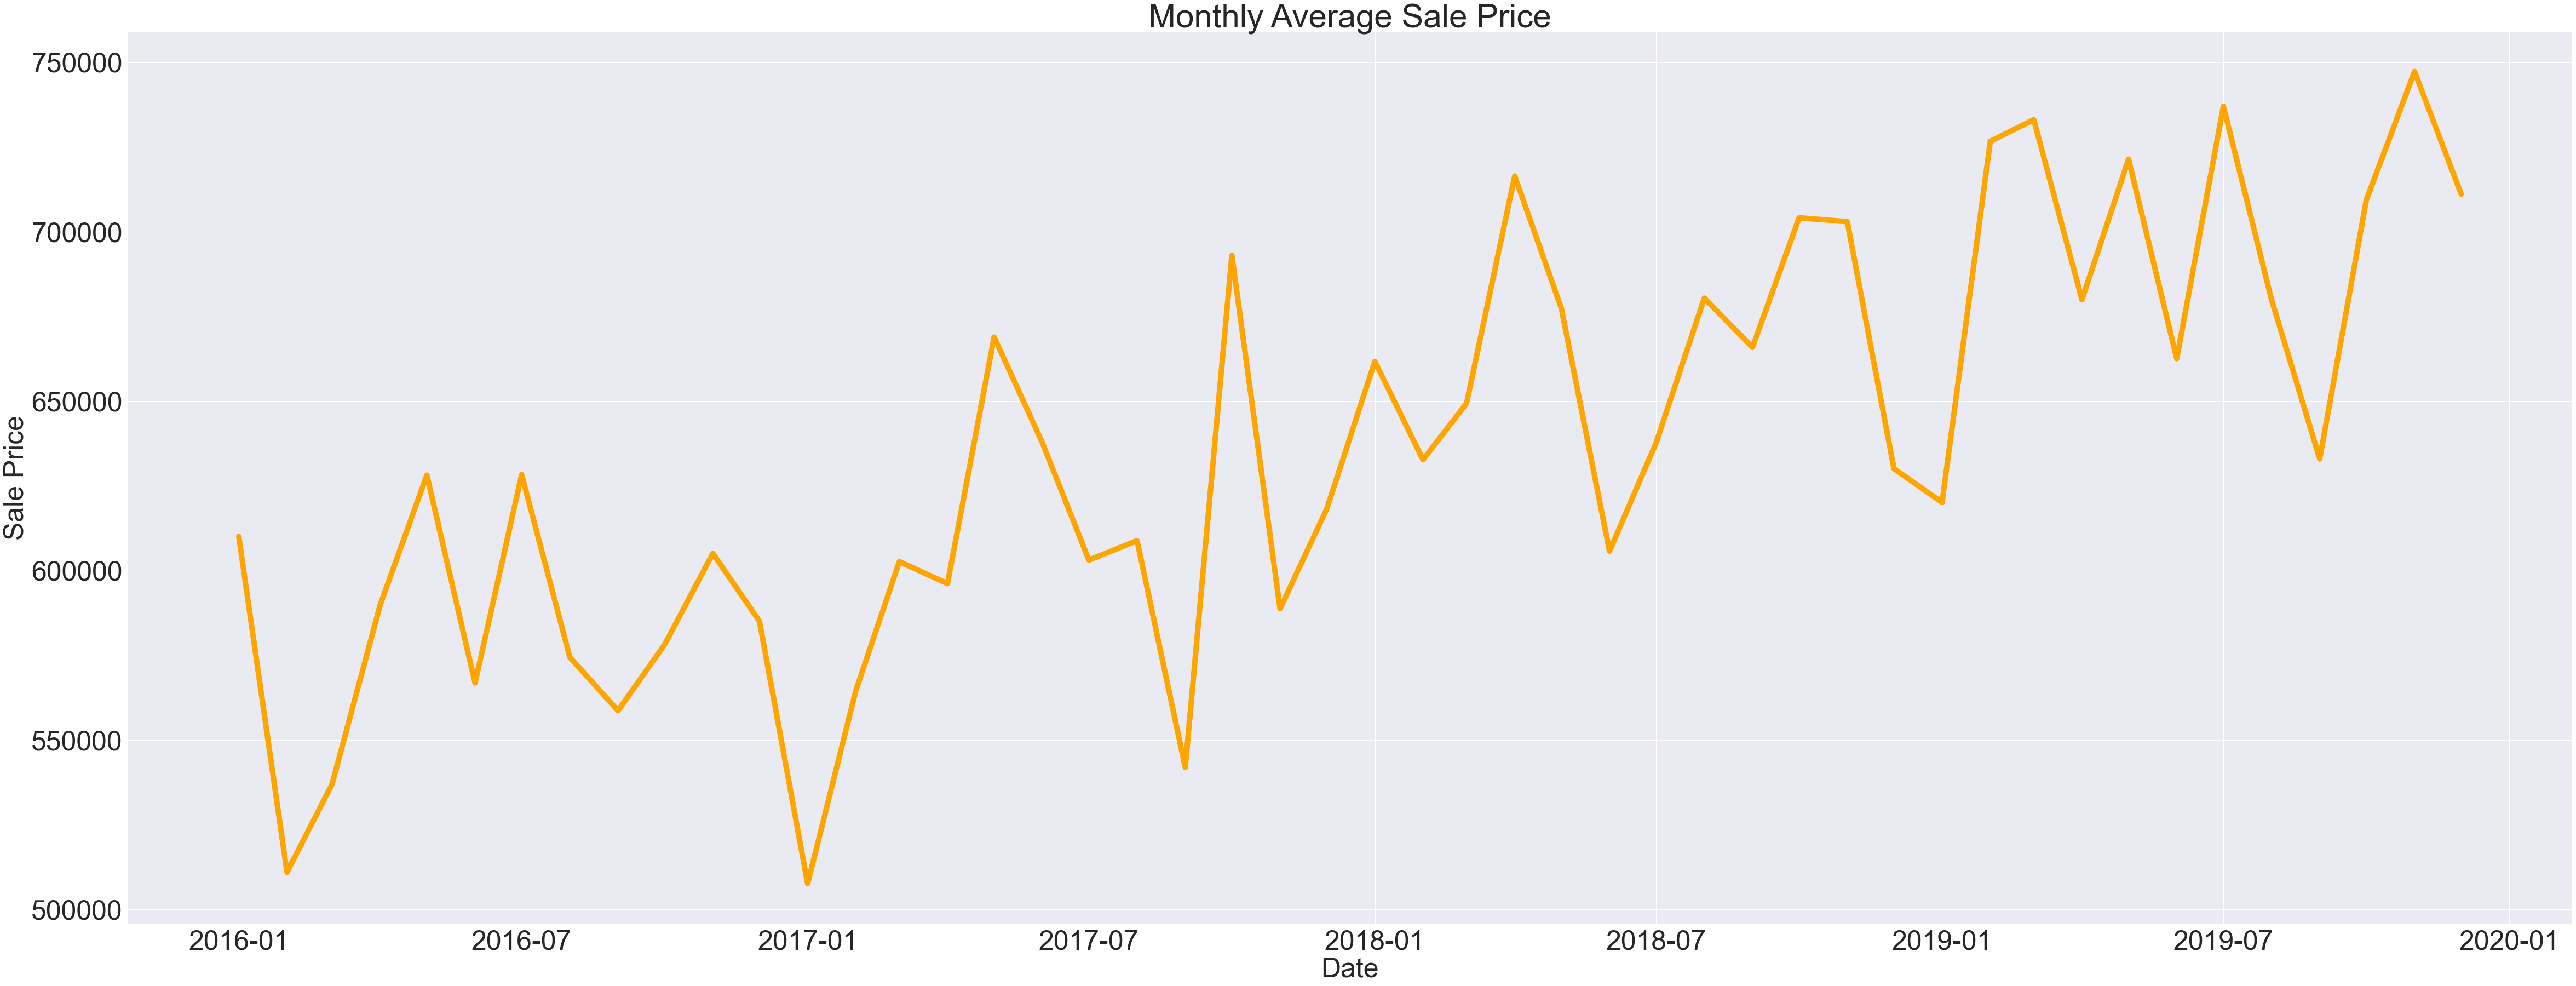

In [15]:
sns.set(rc = {'figure.figsize':(80,30)})
plt.plot(series_train, label='Train', linewidth = 10, color='orange')
plt.title('Monthly Average Sale Price', fontsize=60)
plt.xlabel('Date', fontsize=50)
plt.ylabel('Sale Price', fontsize=50)
plt.xticks(fontsize = 50)
plt.yticks(fontsize = 50)

(array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

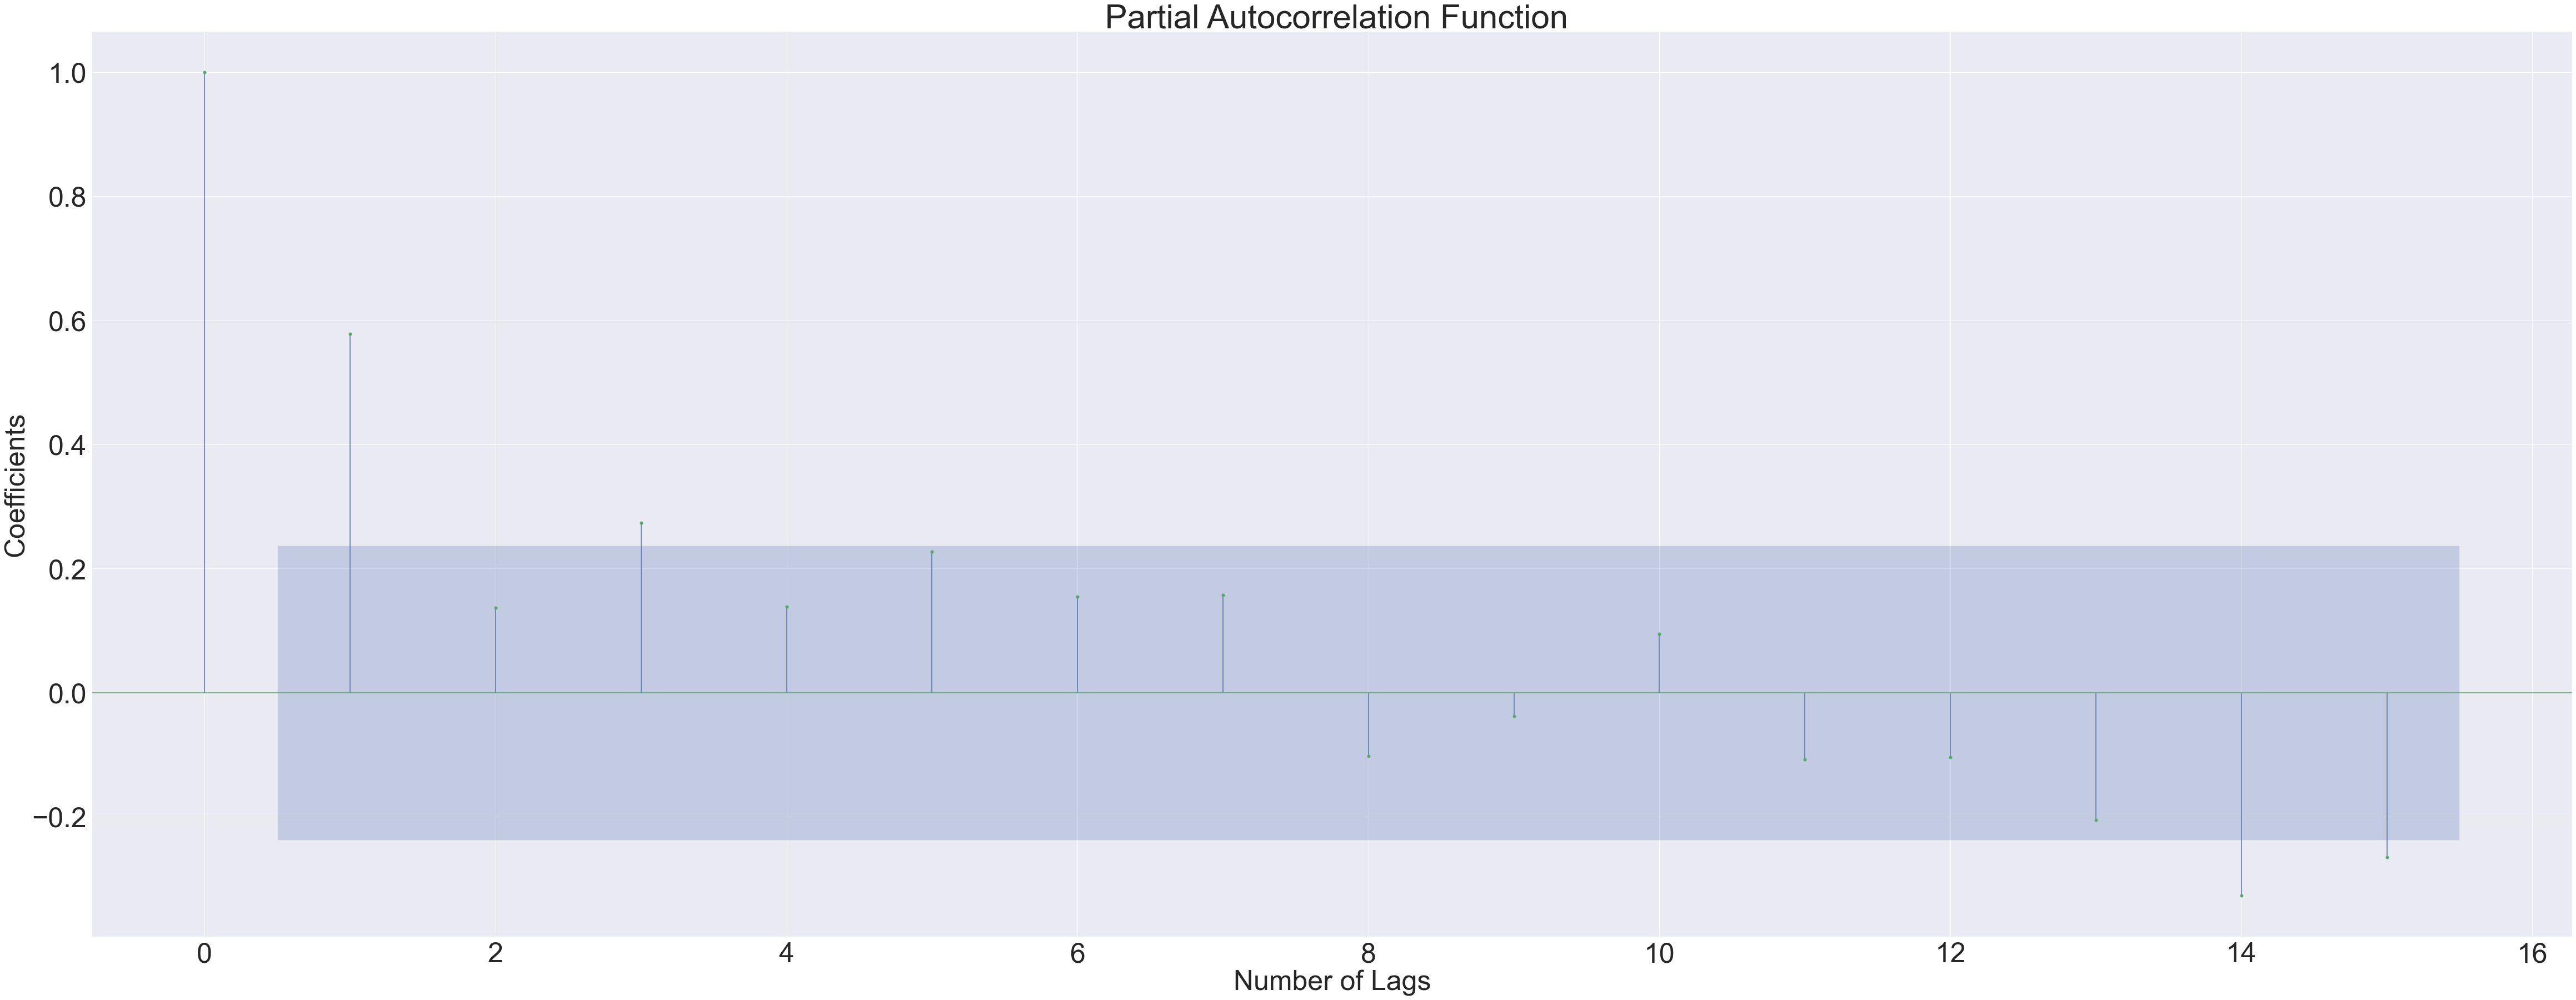

In [72]:
pacf=plot_pacf(series_train, lags=15, color='g', alpha=.1)
plt.title(' Partial Autocorrelation Function',fontsize=60)
plt.xlabel('Number of Lags', fontsize=50)
plt.ylabel('Coefficients', fontsize=50)
plt.xticks(fontsize = 50)
plt.yticks(fontsize = 50)

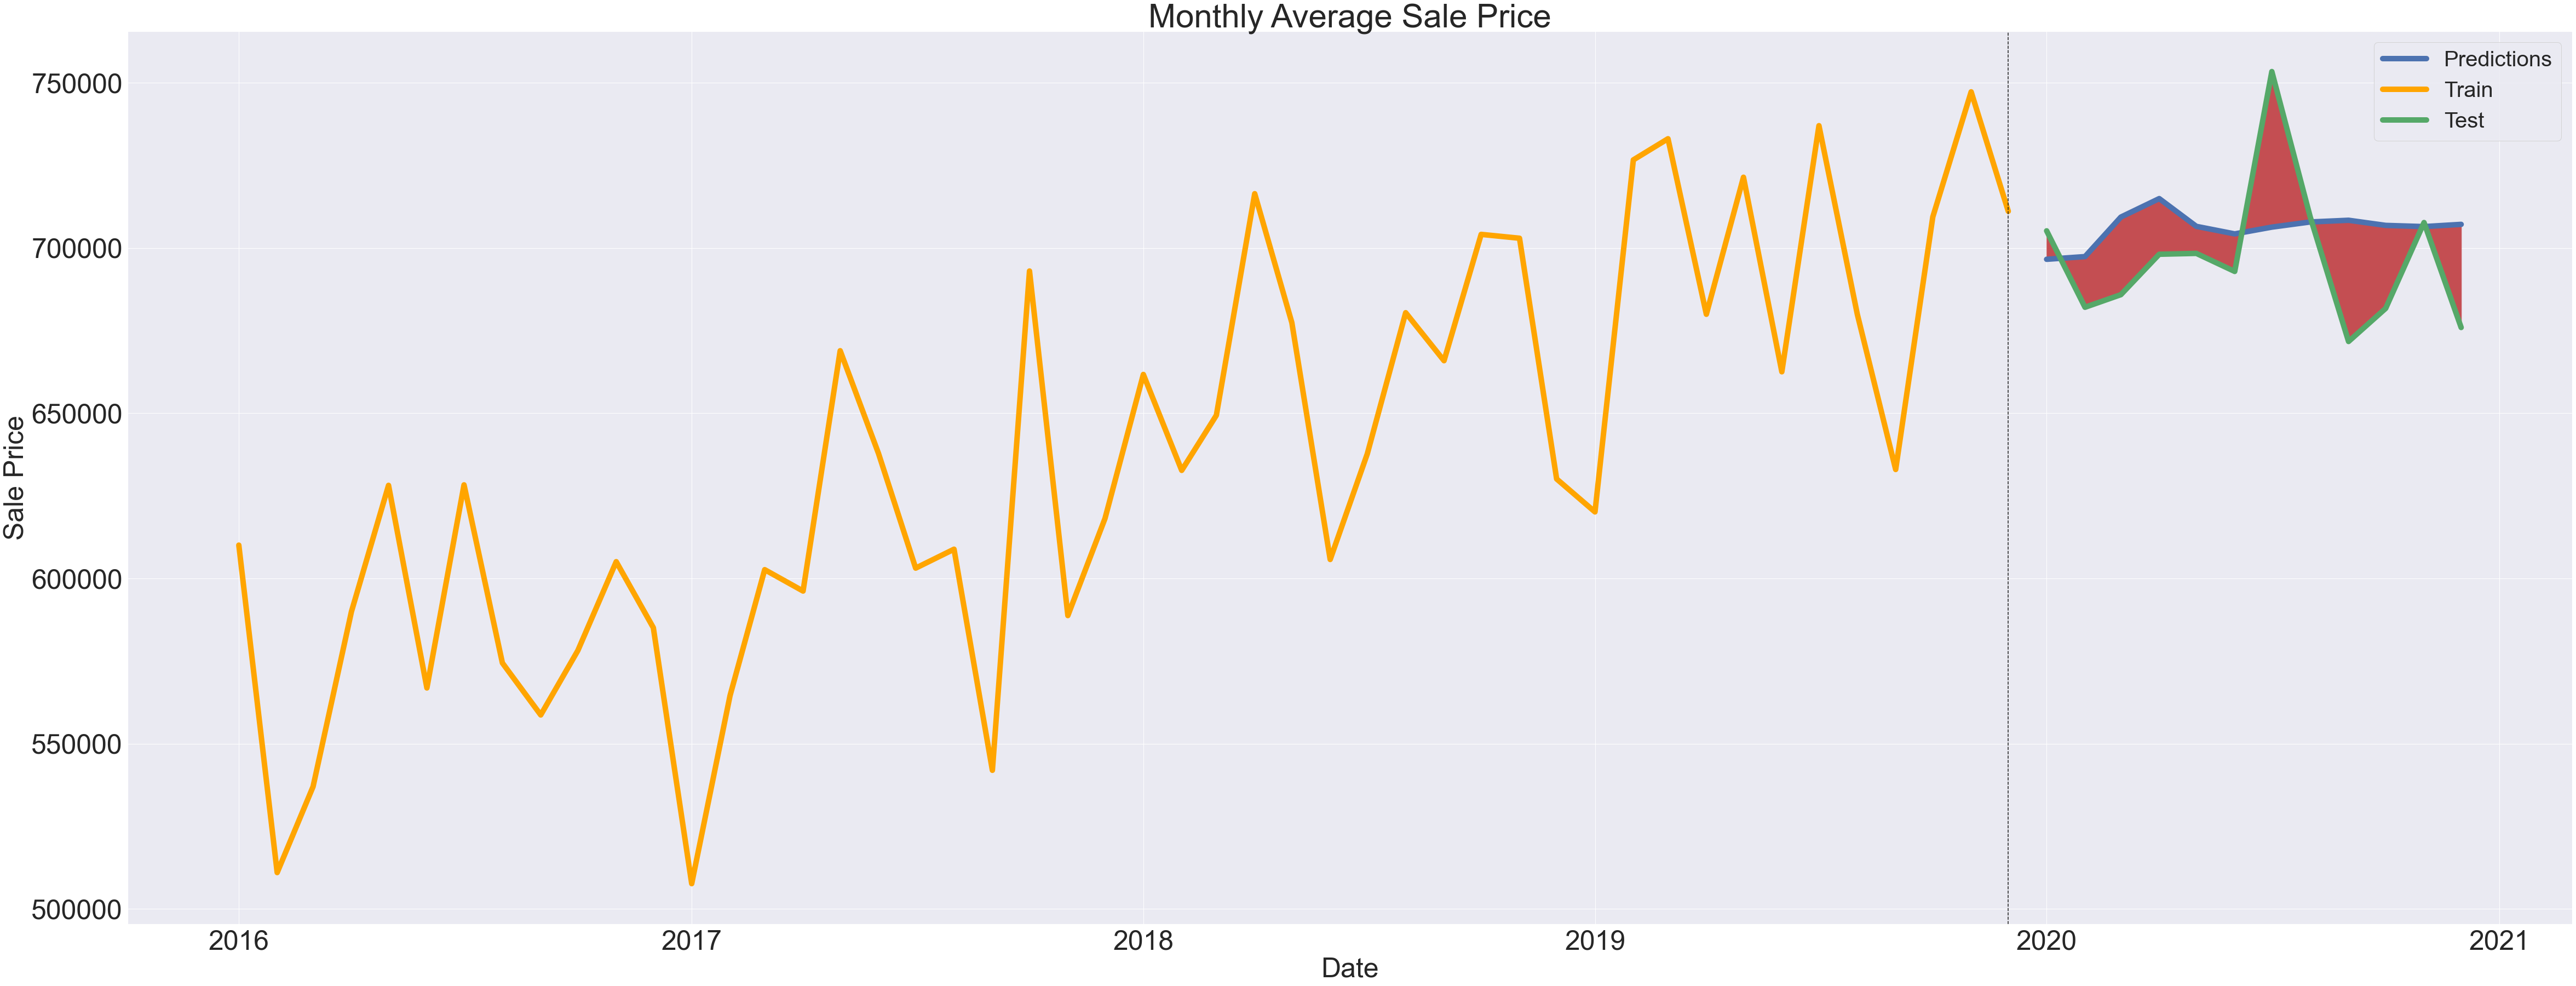

In [73]:
plt.plot(preds, label='Predictions', linewidth = 10, color='b')
plt.plot(series_train, label='Train', linewidth = 10, color='orange')
plt.plot(series_test, label= 'Test', linewidth = 10, color='g')
plt.title('Monthly Average Sale Price', fontsize=60)
plt.xlabel('Date', fontsize=50)
plt.ylabel('Sale Price', fontsize=50)
plt.xticks(fontsize = 50)
plt.yticks(fontsize = 50)
plt.legend(prop={'size': 40})
plt.axvline(series_train.index[len(series_train.index)-1], color='k', linestyle='--')
plt.fill_between(x=preds.index, y1=preds, y2=series_test, color='r')

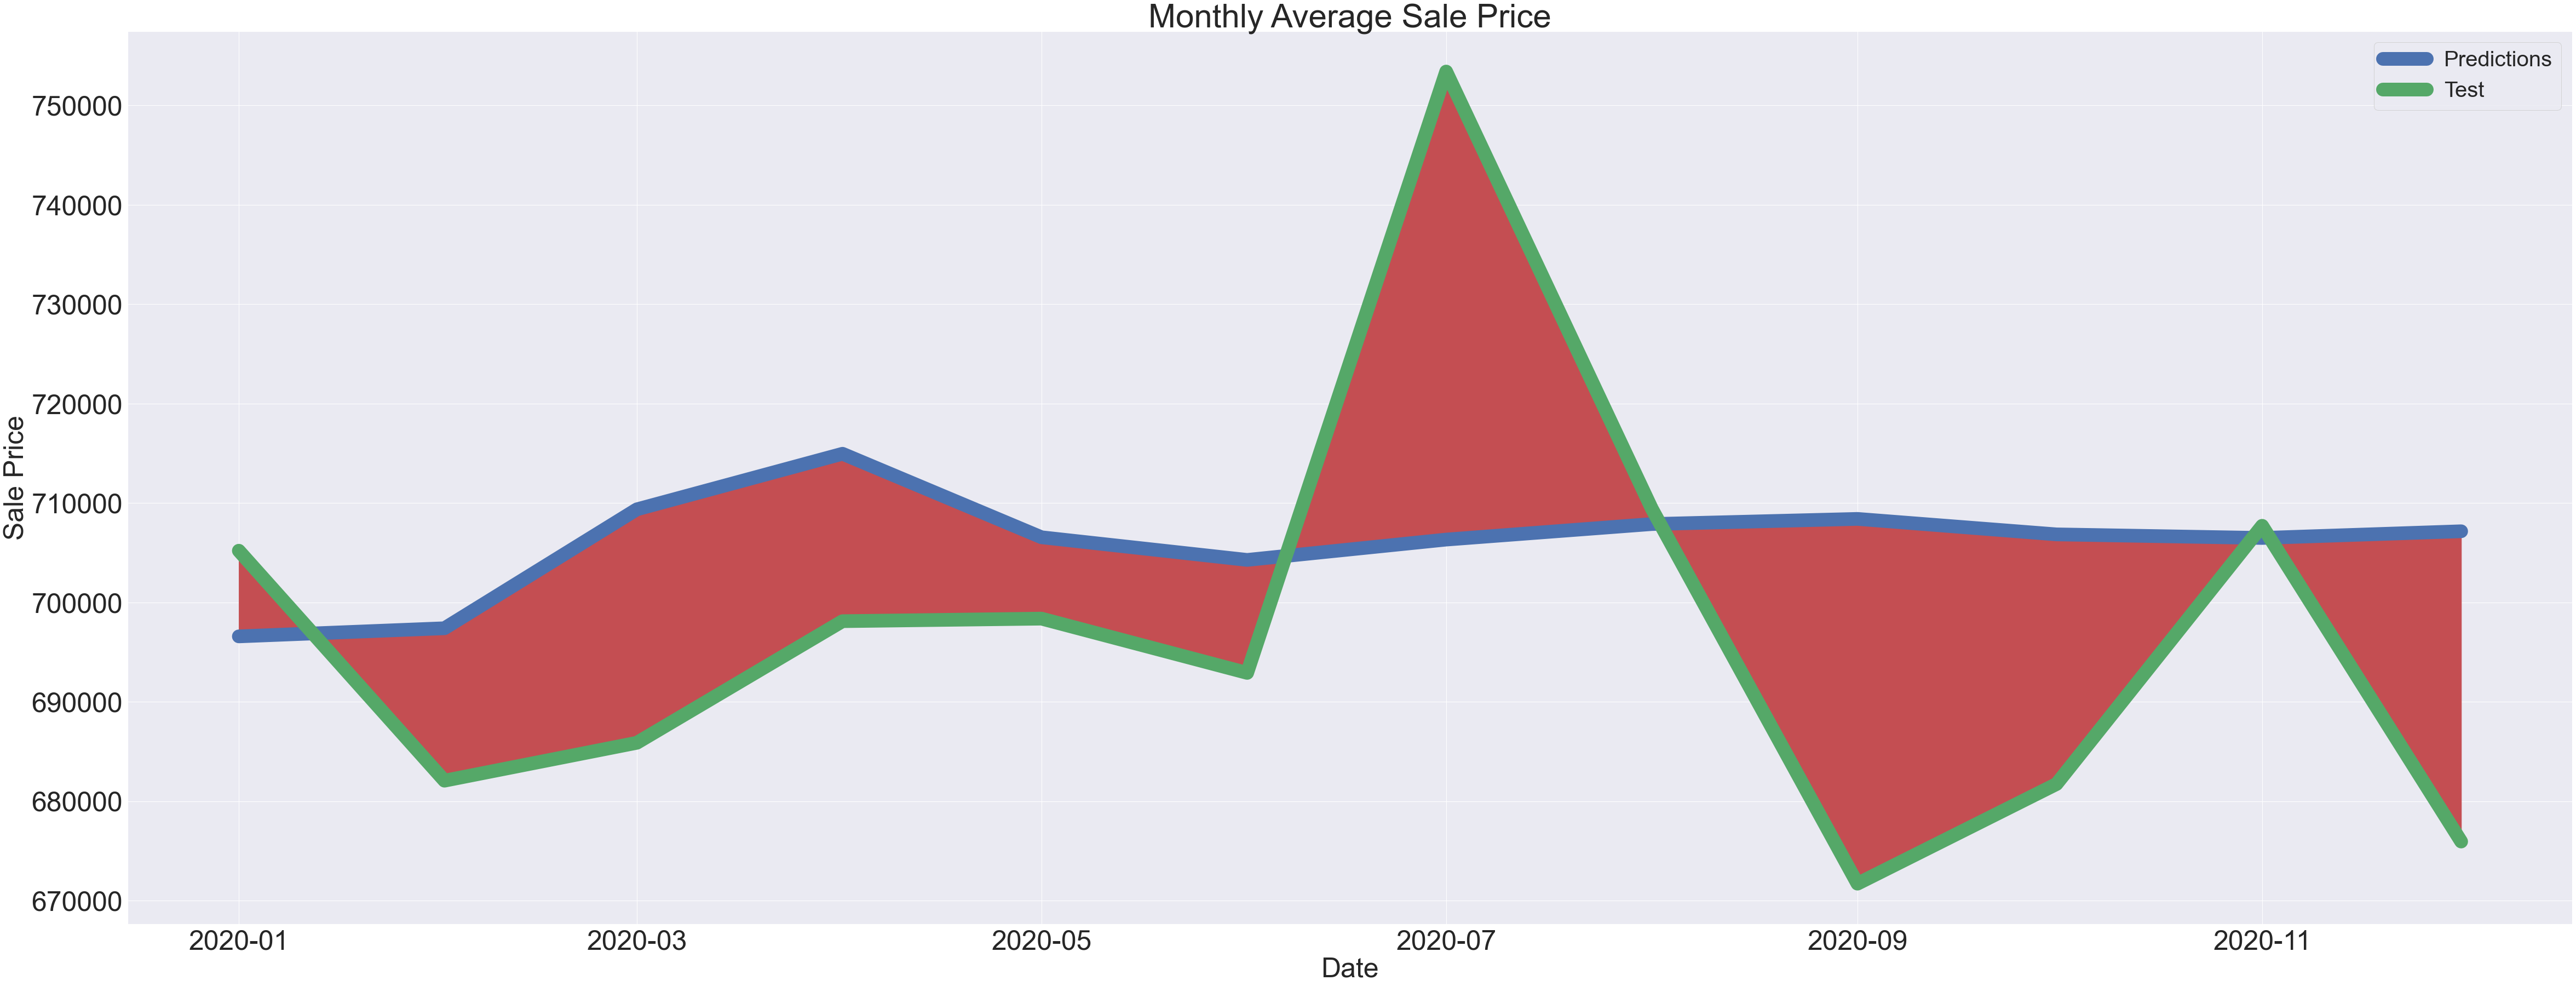

In [74]:
plt.plot(preds, label='Predictions', linewidth = 25, color='b')
plt.plot(series_test, label= 'Test', linewidth = 25, color='g')
plt.title('Monthly Average Sale Price', fontsize=60)
plt.xlabel('Date', fontsize=50)
plt.ylabel('Sale Price', fontsize=50)
plt.xticks(fontsize = 50)
plt.yticks(fontsize = 50)
plt.legend(prop={'size': 40})
plt.fill_between(x=preds.index, y1=preds, y2=series_test, color='r')


In [75]:
RMSE = mean_squared_error(preds,series_test, squared=False)
print(RMSE)

23295.81098059674


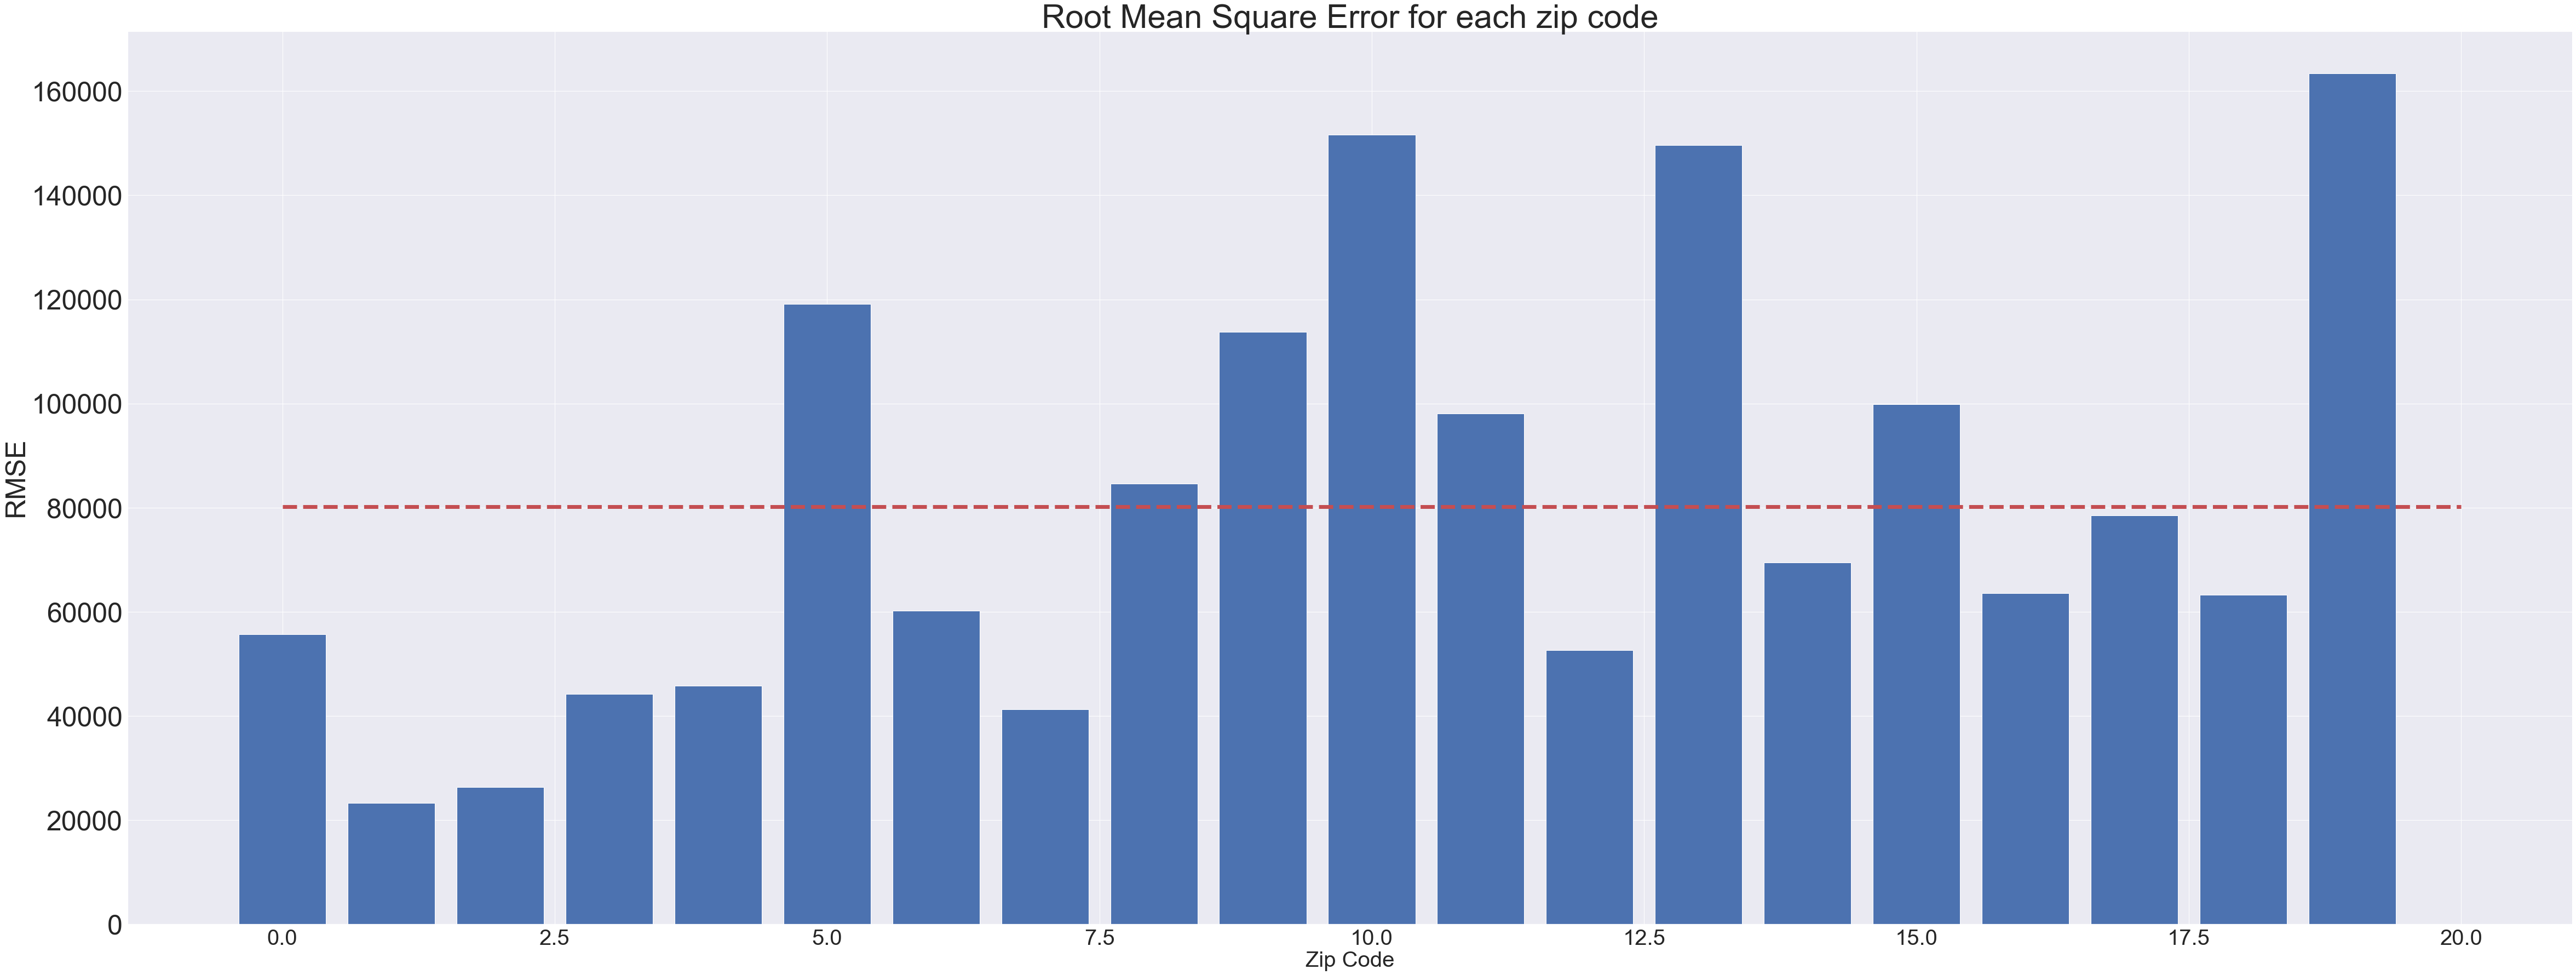

In [76]:
plt.bar(x = range(len(RMSES)), height=RMSES)
RMSES_mean = pd.Series(RMSES).mean()
plt.title('Root Mean Square Error for each zip code', fontsize=60)
plt.xlabel('Zip Code', fontsize=40)
plt.ylabel('RMSE', fontsize=50)
plt.xticks(fontsize = 40)
plt.yticks(fontsize = 50)
plt.plot([0,len(RMSES)],[RMSES_mean,RMSES_mean],'r--',lw=7)
